In [67]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
from IPython.core.display import display, HTML
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from kaggler.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [68]:
train = pd.read_csv('./open/train.csv')
train = train.drop(['index'], axis=1)
#train.fillna('NAN', inplace=True) 


test = pd.read_csv('./open/test.csv')
test = test.drop(['index'], axis=1)
#test.fillna('NAN', inplace=True)

submit = pd.read_csv('./open/sample_submission.csv')

In [69]:
def days_to_age(x):
    return (x*-1)/365

In [70]:
# 마이너스 값 변환
def minus(x):
    return x * -1

In [71]:
def add_var(data):
    data['personal_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str)
    data['personal_begin'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str) + "_" + data['begin_month'].apply(str)

    #data['P_W_E'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str)
    data['gender_reality_car'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
#     data['gender_car'] = data['gender'] + "_" + data['car'] 
#     data['gender_reality'] = data['gender'] + "_" + data['reality'] 
    data['p_w_e_r_c'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) + "_" + data['reality'] + "_" + data['car'] 
    
    return data

train = add_var(train)
test = add_var(test)

In [72]:
def numeric_process(data):
    
    data['income_total'] = data['income_total']/10000
    data['income_total_dev'] = (data['income_total'] - data['income_total'].mean())**2
    data['income_total_log'] = data['income_total'].apply(np.log)
    
    data['DAYS_EMPLOYED_log'] = data['DAYS_EMPLOYED'].map(lambda x: x if x < 0 else 0).apply(lambda x: np.log1p(x*-1))
    data.loc[train['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)
    
    data['begin_month'] = data['begin_month'].apply(minus)
    
    data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)
    
#     data['gender'] = data['gender'].replace(['F','M'],[0,1])
#     data['car'] = data['car'].replace(['N','Y'],[0,1])
#     data['reality'] = data['reality'].replace(['N','Y'],[0,1])
    
#     mapping_edu_type = {
#     'Lower secondary' : 0, # 중학교 미만
#     'Secondary / secondary special' : 1, #중학교
#     'Incomplete higher' : 2, # 고등학교 중퇴
#     'Higher education' : 3, # 고등학교 졸업
#     'Academic degree' : 4 # 학사 이상
#     }
#     data['edu_type'] = data.edu_type.map(mapping_edu_type)
    
#     data['diff_child'] = data['family_size'] - data['child_num']
#     data.loc[data['diff_child'] < 0,'diff_child']=0
#     data.loc[data['diff_child'] > 0,'diff_child']=1
    
    data.loc[data['child_num'] >= 2,'child_num'] = 2
    data.loc[data['family_size'] >= 5,'child_num'] = 5
#     data['diff_child'] = data['diff_child'].astype(int)
#     data['family_size'] = data['family_size'].astype(int)

    #  DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득 Feature 가공. 
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    
    # 가족수와 자녀수 mean, sum 피처 가공
    # data['FAM_CHILD_MEAN'] = data[['child_num', 'family_size']].mean(axis=1)
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    
    # 가족수를 고려한 가처분 소득 피처 가공. 
    #data['CNT_CHILD_INCOME_RATIO'] = data['income_total']/data['child_num']
    data['INCOME_FAM_SUM_RATIO'] = data['income_total']/data['family_size']
    
    # 소유 여부(0/1의 2개 category피처들)와 교육수준 관련 피처들 mean, sum 피처 가공 
#    data['HAVE_OR_NOT_MEAN'] =data[['car','reality','work_phone', 'phone', 'email']].mean(axis=1)
#     data['HAVE_OR_NOT_car_re'] =data[['car','reality']].sum(axis=1)
#     data['family_size_car_reality'] = data[['family_size', 'car', 'reality']].sum(axis=1)
    
#    data['INCOME_HAVE_OR_NOT_RATIO'] = data['income_total']/data['HAVE_OR_NOT_MEAN']
#     data['INCOME_HAVE_OR_NOT_RATIO_car_re'] = data['income_total']/data['HAVE_OR_NOT_car_re']
    
    data['before_EMPLOYED'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    
    return data 

In [73]:
train = numeric_process(train)
test = numeric_process(test)

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 26457 non-null  object 
 1   car                    26457 non-null  object 
 2   reality                26457 non-null  object 
 3   child_num              26457 non-null  int64  
 4   income_total           26457 non-null  float64
 5   income_type            26457 non-null  object 
 6   edu_type               26457 non-null  object 
 7   family_type            26457 non-null  object 
 8   house_type             26457 non-null  object 
 9   DAYS_BIRTH             26457 non-null  float64
 10  DAYS_EMPLOYED          26457 non-null  float64
 11  FLAG_MOBIL             26457 non-null  int64  
 12  work_phone             26457 non-null  int64  
 13  phone                  26457 non-null  int64  
 14  email                  26457 non-null  int64  
 15  oc

In [75]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

print(object_col)

['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'personal_begin', 'gender_reality_car', 'r_c_p_w_e']


In [76]:
def occype_process(data):
    
    # 1. 경력이 없는 사람은 직업군이 결측치임
    # 2. no_work로 대체
    data['occyp_type'] = data['occyp_type'].fillna('NONE')
    data.loc[data['DAYS_EMPLOYED'] > 0, 'occyp_type'] = 'NO_WORK'
    #data.loc[(data['income_type'] == 'Student') & (data['occyp_type'] == 'NONE'), 'occyp_type'] = 'other_work'
    #data['all_type'] =  data['income_type'].astype(str) + "_" + data['edu_type'].astype(str) + "_" + data['family_type'].astype(str) + "_" + data['house_type']
    
    return data

train = occype_process(train)
test = occype_process(test)

In [77]:
def type_process(data):
    data['income_edu'] = data['income_type'] + "_" + data['edu_type'] 
    data['income_fam'] = data['income_type'] + "_" + data['family_type'] 
    data['income_hous'] = data['income_type'] + "_" + data['house_type'] 
    data['edu_fam'] = data['edu_type'] + "_" + data['family_type'] 
    data['edu_hous'] = data['edu_type'] + "_" + data['house_type'] 
    data['fam_hous'] = data['family_type'] + "_" + data['house_type'] 

    return data
# train = type_process(train)
# test = type_process(test)

In [78]:
#minus 변경하고
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    #data[variable] =- data[variable]
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]

In [79]:
make_bin(train, 'DAYS_BIRTH', n=10)
# make_bin(train, 'income_total_log', n=25)
# make_bin(train, 'DAYS_EMPLOYED_log', n=15)
#make_bin(train, 'begin_month', n=6)
make_bin(test, 'DAYS_BIRTH', n=10)
# make_bin(test, 'income_total_log', n=25)
# make_bin(test, 'DAYS_EMPLOYED_log', n=15)
#make_bin(test, 'begin_month', n=6)

In [80]:
train = train.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)
test = test.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 26457 non-null  object 
 1   car                    26457 non-null  object 
 2   reality                26457 non-null  object 
 3   child_num              26457 non-null  int64  
 4   income_type            26457 non-null  object 
 5   edu_type               26457 non-null  object 
 6   family_type            26457 non-null  object 
 7   house_type             26457 non-null  object 
 8   DAYS_BIRTH             26457 non-null  float64
 9   work_phone             26457 non-null  int64  
 10  phone                  26457 non-null  int64  
 11  email                  26457 non-null  int64  
 12  occyp_type             26457 non-null  object 
 13  family_size            26457 non-null  float64
 14  begin_month            26457 non-null  float64
 15  cr

In [95]:
random.seed(42)
cat_models={}

train_x = train.drop(['credit'],axis=1)
train_y = train['credit']
cat_features = [0,1,2,4,5,6,7,12,15,16,17,18]
random_seed = [1042]

""
def run_kfold():
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=3000, max_depth=8, random_seed=seed, learning_rate =0.041)
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50, cat_features=cat_features,
                  verbose=100)


            cat_models[n_fold] = cat

            predictions = cat.predict_proba(X_val)
            test_predictions = cat.predict_proba(test)

            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            sub+= test_predictions

            print(f'================================================================================\n\n')

    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    return sub/(folds.n_splits * len(random_seed))
    
my_submission = run_kfold()

====================================1============================================
0:	learn: 1.0749258	test: 1.0749155	test1: 1.0752826	best: 1.0752826 (0)	total: 190ms	remaining: 9m 31s
100:	learn: 0.7133510	test: 0.5147096	test1: 0.6913643	best: 0.6913643 (100)	total: 13.4s	remaining: 6m 25s
200:	learn: 0.6936265	test: 0.4901323	test1: 0.6836918	best: 0.6836635 (195)	total: 29.6s	remaining: 6m 51s
300:	learn: 0.6773197	test: 0.4788664	test1: 0.6816678	best: 0.6816363 (299)	total: 45.6s	remaining: 6m 49s
400:	learn: 0.6614641	test: 0.4697313	test1: 0.6805480	best: 0.6805067 (399)	total: 1m 1s	remaining: 6m 41s
500:	learn: 0.6459016	test: 0.4614140	test1: 0.6797510	best: 0.6796898 (496)	total: 1m 18s	remaining: 6m 31s
600:	learn: 0.6303453	test: 0.4554886	test1: 0.6787026	best: 0.6787026 (600)	total: 1m 35s	remaining: 6m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6781134722
bestIteration = 641

Shrink model to first 642 iterations.
FOLD 1 : logloss:0.6781134

FOLD 9 : logloss:0.6754288373787813


====================================10============================================
0:	learn: 1.0747704	test: 1.0747278	test1: 1.0746145	best: 1.0746145 (0)	total: 192ms	remaining: 9m 37s
100:	learn: 0.7129043	test: 0.5137807	test1: 0.6682423	best: 0.6682423 (100)	total: 17.1s	remaining: 8m 11s
200:	learn: 0.6944149	test: 0.4900623	test1: 0.6613640	best: 0.6613640 (200)	total: 37.9s	remaining: 8m 48s
300:	learn: 0.6795955	test: 0.4785565	test1: 0.6600835	best: 0.6600494 (296)	total: 1m	remaining: 8m 59s
400:	learn: 0.6633750	test: 0.4715007	test1: 0.6593794	best: 0.6592749 (378)	total: 1m 22s	remaining: 8m 52s
500:	learn: 0.6478337	test: 0.4670297	test1: 0.6584962	best: 0.6581753 (479)	total: 1m 43s	remaining: 8m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6581753382
bestIteration = 479

Shrink model to first 480 iterations.
FOLD 10 : logloss:0.6581753382044214


Mean:0.6670923968299302


In [85]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


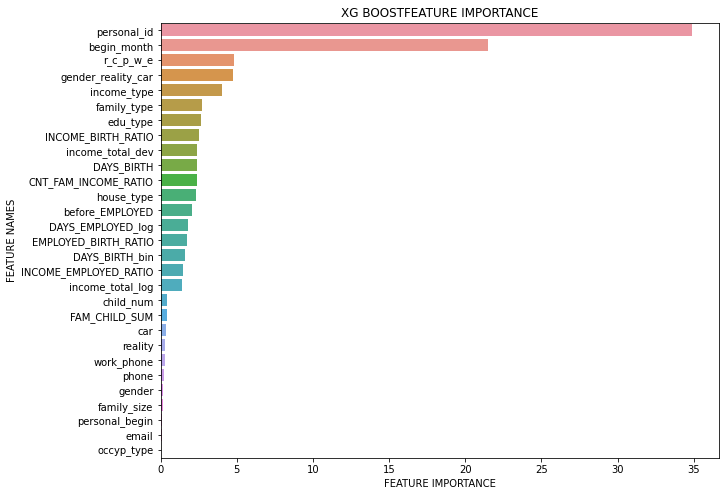

In [86]:
#plot the xgboost result
plot_feature_importance(cat_models[0].get_feature_importance(), train_x.columns,'XG BOOST')

In [270]:
def catboost_eval(
                  depth , 
                  learning_rate ,
                  min_data_in_leaf , 
                  border_count):
    
    train_x = train.drop(['credit'],axis=1)
    train_y = train['credit']
    cat_features = [0,1,2,4,5,6,7,12,15,16,17]
    
    n_splits=5
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    predict = None
    params = {}
    params['n_estimators'] = 500
    params['random_seed'] = 42
    params['learning_rate'] = learning_rate
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['depth'] = int(round(depth))
    params['border_count'] = int(round(border_count))
    #params['bagging_temperature'] = int(round(bagging_temperature))
    
    outcomes=[]
    
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        
        cat = CatBoostClassifier(**params , langevin=True)
        cat.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              early_stopping_rounds=20, cat_features=cat_features,
              verbose=100)

        predictions = cat.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        print(f'================================================================================\n\n')
        
    mean_outcome=np.mean(outcomes)
    print("Mean:{}\n\n".format(mean_outcome))
    
    return mean_outcome



In [271]:
# from bayes_opt import BayesianOptimization
# import xgboost as xgb
# import catboost as cat

# catBO = BayesianOptimization(catboost_eval,
#                              {
#                               'depth': (4, 12) ,
#                               "learning_rate" : (0.001,0.2) , 
#                               "min_data_in_leaf" : (1,100) , 
#                               'border_count': (5, 255) ,
#                              },
#                              random_state=0)
# init_round=5
# opt_round = 5
# catBO.maximize(init_points=init_round, n_iter=opt_round)

In [272]:
# params = catBO.max['params']
# params

{'border_count': 5.414726998321097,
 'depth': 5.617240356933636,
 'learning_rate': 0.14872937961739185,
 'min_data_in_leaf': 46.44547293947302}

In [123]:
my_submission

array([[0.12700415, 0.16743016, 0.70556569],
       [0.34075217, 0.23452028, 0.42472755],
       [0.04628393, 0.07668607, 0.87703   ],
       ...,
       [0.04956436, 0.11497409, 0.83546154],
       [0.14781934, 0.30184033, 0.55034033],
       [0.06784331, 0.43972024, 0.49243645]])

In [124]:
submission=pd.read_csv('./open/sample_submission.csv')
submission.loc[:,1:]=my_submission
submission

,index,0,1,2
0,26457,0.127004,0.167430,0.705566
1,26458,0.340752,0.234520,0.424728
2,26459,0.046284,0.076686,0.877030
3,26460,0.071051,0.091659,0.837290
4,26461,0.079916,0.233380,0.686704
...,...,...,...,...
9995,36452,0.078513,0.230803,0.690684
9996,36453,0.128730,0.422281,0.448990
9997,36454,0.049564,0.114974,0.835462
9998,36455,0.147819,0.301840,0.550340


In [125]:
submission.to_csv('./submit/10fold_cat_0.6676868751352338.csv', index=False) # 0.7272812144

In [126]:
submission.head(20)

,index,0,1,2
0,26457,0.127004,0.167430,0.705566
1,26458,0.340752,0.234520,0.424728
2,26459,0.046284,0.076686,0.877030
3,26460,0.071051,0.091659,0.837290
4,26461,0.079916,0.233380,0.686704
5,26462,0.059987,0.139189,0.800823
6,26463,0.555978,0.406500,0.037522
7,26464,0.055597,0.095306,0.849097
8,26465,0.068582,0.096611,0.834808
9,26466,0.056972,0.270026,0.673003
